In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import numpy as np
from matplotlib import pyplot as plt
import os
import shutil
import librosa
import librosa.display
import IPython.display as ipd

In [30]:
#!git clone https://github.com/microsoft/MS-SNSD.git

In [31]:
# dataset_folders = ["clean_test", "clean_train", "noise_test", "noise_train", "hitapps"]
# repo_path = "MS-SNSD"
# drive_path = "/content/drive/MyDrive/White Noise project/Dataset"

# for folder in dataset_folders:
#   source = os.path.join(repo_path, folder)
#   destination = os.path.join(drive_path, folder)
#   shutil.copytree(source, destination)
#   print(f"{folder} copied to google drive")

In [32]:
# shutil.rmtree(repo_path)
# print("cloned repository deleted from colab's memory")

In [33]:
clean_sample = "/content/drive/MyDrive/White Noise project/Dataset/clean_train/p234_034.wav"
noise_sample = "/content/drive/MyDrive/White Noise project/Dataset/noise_train/AirConditioner_4.wav"

signal_clean, sr = librosa.load(clean_sample, sr = 44100, duration = 4)
signal_noise, _ = librosa.load(noise_sample, sr = 44100, duration = 4)

In [34]:
ipd.Audio(clean_sample)

In [35]:
ipd.Audio(noise_sample)

In [36]:
print(signal_clean.shape)
print(signal_noise.shape)

(176400,)
(176400,)


In [37]:
def plot_samples(signal_clean, signal_noise, sr):
  plt.figure(figsize = (12,7))

  #plot the sample_clean
  plt.subplot(2, 1, 1)
  librosa.display.waveshow(signal_clean, sr = sr, alpha = 0.5)
  plt.ylim((-1,1))
  plt.title("Sample without noise")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")


  #plot the sample_noise
  plt.subplot(2, 1, 2)
  librosa.display.waveshow(signal_noise, sr = sr, alpha = 0.5)
  plt.ylim((-1,1))
  plt.title("Sample with noise")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")

  plt.tight_layout()
  plt.show()

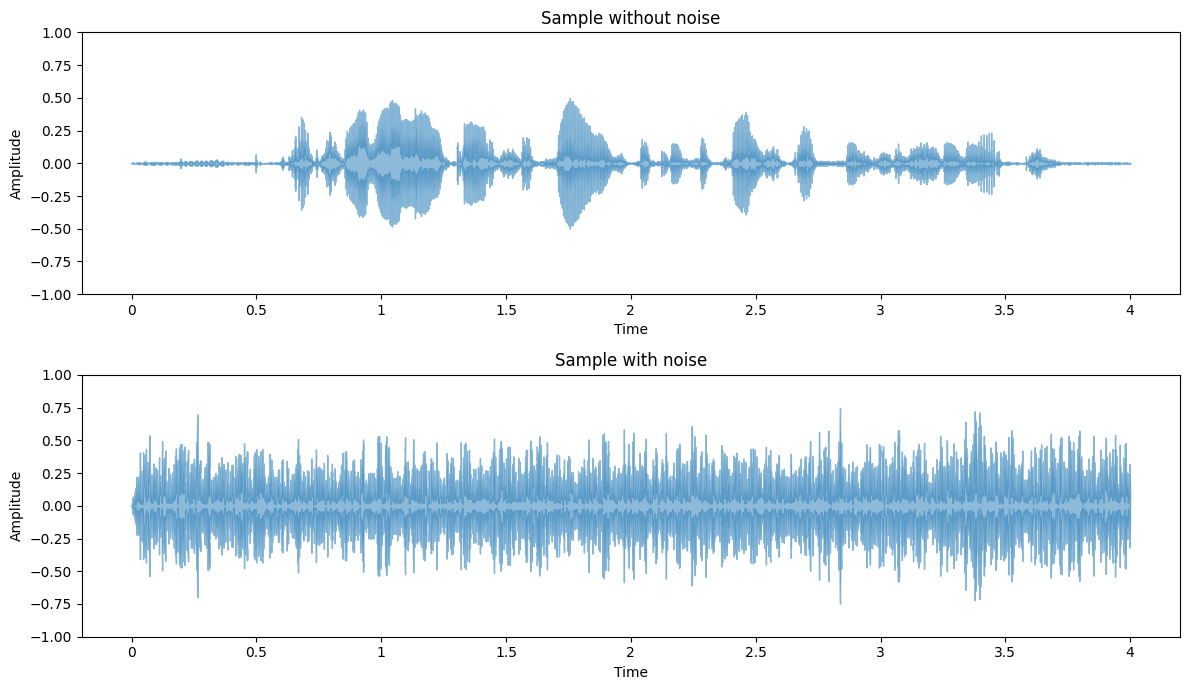

In [38]:
plot_samples(signal_clean, signal_noise, sr)

In [39]:
# Constants defining parameters for frame-based analysis of time-domain signals
FRAME_LENGTH = 512
HOP_LENGTH = 256

In [40]:
def amplitude_envelope(signal, frame_length = FRAME_LENGTH, hop_length = HOP_LENGTH):
  """
    Computes the amplitude envelope of a signal.

    Parameters:
    - signal (numpy.ndarray): The input signal.
    - frame_length (int, optional): The size of each analysis frame. Defaults to FRAME_LENGTH(1024).
    - hop_length (int, optional): The number of samples between adjacent frames. Defaults to HOP_LENGTH(512).

    Returns:
    - numpy.ndarray: An array containing the maximum amplitude value within each frame.
  """
  return np.array([max(signal[i:i+frame_length]) for i in range(0, signal.size, hop_length)])

In [41]:
# Calculate the amplitude envelope for both clean and noise signals

ae_signal_clean = amplitude_envelope(signal_clean, FRAME_LENGTH, HOP_LENGTH)
ae_signal_noise = amplitude_envelope(signal_noise, FRAME_LENGTH, HOP_LENGTH)

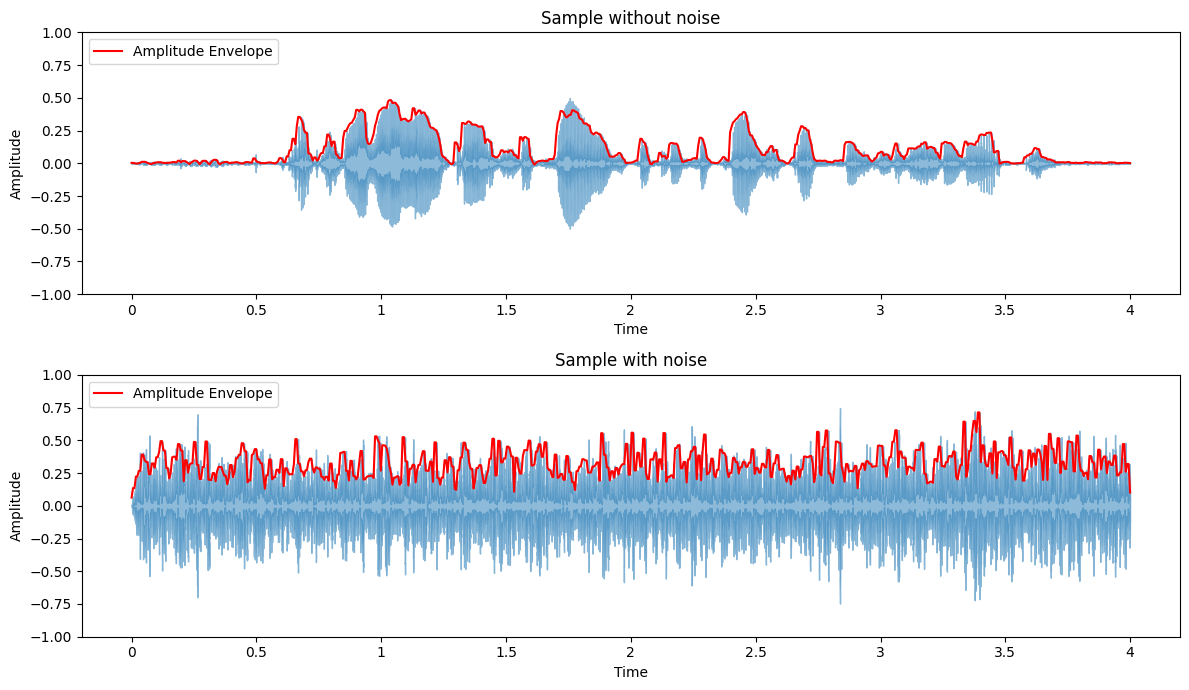

In [42]:
# Convert frame indices to time values
frames = range(len(ae_signal_clean))
time = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)/2


# Plot the amplitude envelope for both samples, with and without noise
plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
librosa.display.waveshow(signal_clean, sr = sr, alpha = 0.5)
plt.plot(time, ae_signal_clean, color = "r", label="Amplitude Envelope")
plt.ylim((-1 , 1))
plt.title("Sample without noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc = "upper left")

plt.subplot(2, 1, 2)
librosa.display.waveshow(signal_noise, sr = sr, alpha = 0.5)
plt.plot(time, ae_signal_noise, color = "r", label="Amplitude Envelope")
plt.ylim((-1 , 1))
plt.title("Sample with noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc = "upper left")


plt.tight_layout()
plt.show()

In [43]:
def rms(signal, frame_length, hop_length):
  """
    Compute the root mean square (RMS) energy for each analysis frame in a signal.

    Parameters:
    - signal (numpy.ndarray): The input signal.
    - frame_length (int): The size of each analysis frame.
    - hop_length (int): The number of samples between adjacent frames.

    Returns:
    - numpy.ndarray: An array containing the RMS energy for each frame.
  """
  rms = []

  for i in range(0, len(signal), hop_length):
    rms_current_frame = np.sqrt((np.sum(signal[i:i+frame_length]**2)) / frame_length)
    rms.append(rms_current_frame)

  return np.array(rms)

In [44]:
# Calculate the Root Mean Square (RMS) energy for both clean and noise signals

rms_signal_clean = rms(signal_clean, FRAME_LENGTH, HOP_LENGTH)
rms_signal_noise = rms(signal_noise, FRAME_LENGTH, HOP_LENGTH)

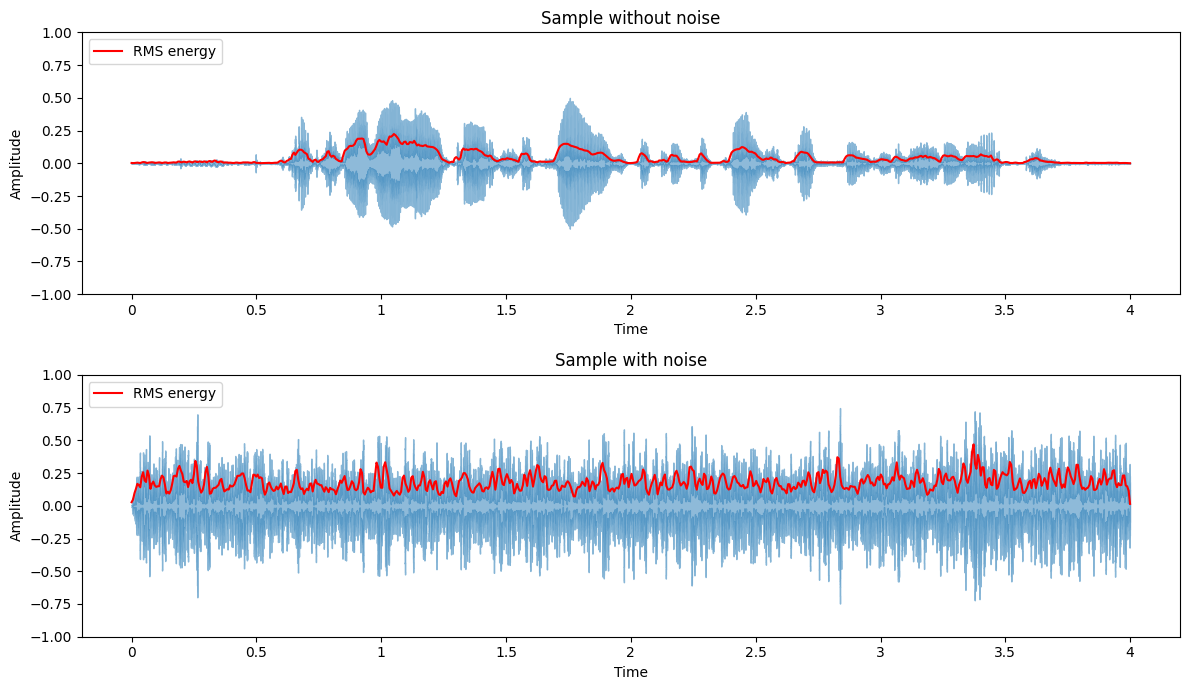

In [45]:
# Convert frame indices to time values
frames = range(len(rms_signal_clean))
time = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)/2

# Plotting the root-mean-square energy (RMSE) for both clean and noise signals over time
plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
librosa.display.waveshow(signal_clean, sr = sr, alpha = 0.5)
plt.plot(time, rms_signal_clean, color = "r", label="RMS energy")
plt.ylim((-1 , 1))
plt.title("Sample without noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc = "upper left")

plt.subplot(2, 1, 2)
librosa.display.waveshow(signal_noise, sr = sr, alpha = 0.5)
plt.plot(time, rms_signal_noise, color = "r", label="RMS energy")
plt.ylim((-1 , 1))
plt.title("Sample with noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc = "upper left")


plt.tight_layout()
plt.show()

In [46]:
# Calculate the Zero Crossing Rate (ZCR) for both clean and noise signals

zcr_signal_clean = librosa.feature.zero_crossing_rate(signal_clean, frame_length = FRAME_LENGTH, hop_length = HOP_LENGTH)[0]
zcr_signal_noise = librosa.feature.zero_crossing_rate(signal_noise, frame_length = FRAME_LENGTH, hop_length = HOP_LENGTH)[0]

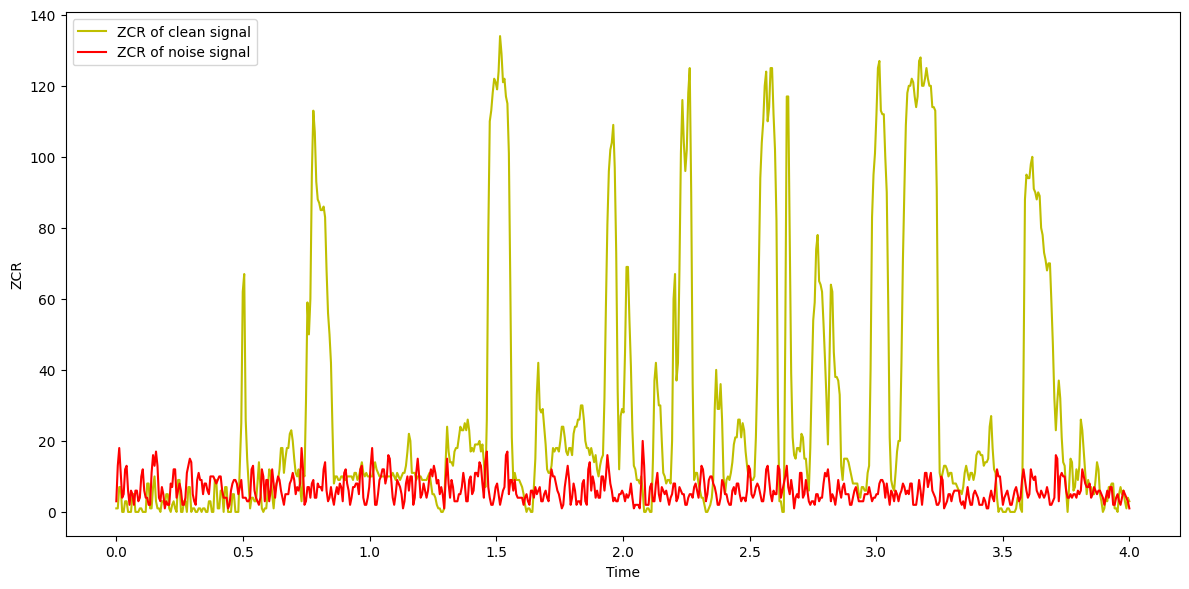

In [47]:
# Convert frame indices to time values
frames = range(len(zcr_signal_clean))
time = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)/2


# Plotting the Zero Crossing Rate (ZCR) for both clean and noise signals over time

plt.figure(figsize = (12,6))
plt.plot(time, zcr_signal_clean * FRAME_LENGTH, color = "y", label = "ZCR of clean signal")
plt.plot(time, zcr_signal_noise * FRAME_LENGTH, color = "r", label = "ZCR of noise signal")
plt.xlabel("Time")
plt.ylabel("ZCR")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()
